# 肩の高さ・位置を指摘する

In [59]:
# 画像を受け取り
# 正常・傾き・回転・検出失敗のフラグを返す

In [60]:
# 補助線を描画すること
# 背景を0にする（消す）
# 頭頂部で区切る->最初の線
# 顔より下
# 顔幅+1.5までのx軸

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [37]:
def detect_shoulder(image_path):
    resized_image, gray_image = color_to_gray(image_path) # グレースケール変換
#     thresh = to_thresh_binary_inv(gray_image) # 閾値
#     median = cv2.medianBlur(thresh,7) # ごま塩ノイズ
#     blur = cv2.GaussianBlur(thresh,(5,5),0)
    canny_image = cv2.Canny(gray_image, 50, 110) # エッジ変換 
    lines = hough_lines_p(resized_image, canny_image) # ハフ変換
    result = judge_shoulder(lines, resized_image) # 結果取得
    return result

# 画像サイズを整える

In [5]:
def get_resize_rate(width, height):
    if width > 2000 or height > 2000:
        x_rate = 0.15
        y_rate = 0.15
    elif width > 1000 or height > 1000:
        x_rate = 0.5
        y_rate = 0.5
    else:
        x_rate = 1
        y_rate = 1
    return x_rate, y_rate

# 画像を読み込む
# グレースケールに変換する

In [36]:
def color_to_gray(input_path):
    raw_image = cv2.imread(input_path)
    height, width, channels = raw_image.shape[:3]
    x_rate, y_rate = get_resize_rate(width, height)
    resized_image = cv2.resize(raw_image, dsize=None, fx=x_rate, fy=y_rate)
    gray_image = cv2.cvtColor(resized_image,cv2.COLOR_BGR2GRAY)
    return resized_image, gray_image

In [7]:
resized_image, gray_image = color_to_gray('./data/images/image.jpg')
print(gray_image.shape)

(307, 230)


In [8]:
# 読み込みと同時にグレースケール変換
# gray_image = cv2.imread('./data/images/image.jpg',cv2.IMREAD_GRAYSCALE)

In [9]:
# グレースケール画像を保存する 
# cv2.imwrite('./data/images/output.jpg', gray_image)

# 閾値でパキッと

In [10]:
def to_thresh_binary_inv(gray_image):
    ret,thresh = cv2.threshold(gray_image,110,255,cv2.THRESH_BINARY_INV)
    return thresh
#     plt.imshow(thresh,'gray')

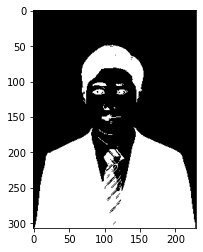

In [11]:
resuzed_image, gray_image = color_to_gray('./data/images/image.jpg')
thresh = to_thresh_binary_inv(gray_image)
plt.imshow(thresh, 'gray')

In [12]:
np.shape(thresh)

(307, 230)

In [13]:
# THRESH_BINARY: パキッと
# _INV: openCV は背景が黒、物体が白なので反転する

# エッジ変換

In [14]:
def to_canny_img(gray_image):
    canny_image = cv2.Canny(gray_image, 50, 110)
    plt.imshow(canny_image)

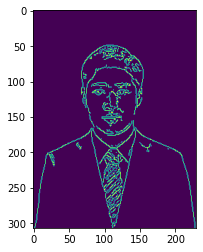

In [15]:
resized_image, gray_image = color_to_gray('./data/images/image.jpg')
to_canny_img(gray_image)

# 輪郭検出

In [16]:
def detect_contours(input_path):
    resized_image, gray_image = color_to_gray(input_path)
    ret,thresh = cv2.threshold(gray_image,115,255,cv2.THRESH_BINARY_INV)
    image, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
     # 小さい輪郭は除く
    contours = list(filter(lambda x: cv2.contourArea(x) >3000, contours))
    cv2.drawContours(resized_image, contours, -1, (0, 255, 0), 2)
    plt.imshow(resized_image)

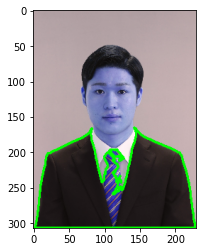

In [17]:
detect_contours('./data/images/image.jpg')

In [18]:
# image = cv2.drawContours(mono_image, contours, -1, (0,255,0), 3)

## 輪郭近似

In [19]:
# 輪郭描画
# for i in range(len(contours)):
#     if hierarchy[0][i][3] == -1:
#         cv2.drawContours(resized_image, contours, i, (0, 255, 0), 2)
# plt.imshow(resized_image)

In [20]:
# cnt = contours[0]
# epsilon = 0.5*cv2.arcLength(cnt,True)
# approx = cv2.approxPolyDP(cnt,epsilon,True)

In [21]:
# cv2.drawContours(resized_image, [approx], -1, (0, 255, 0), 2)
# plt.imshow(resized_image)

# 直線検出

## 確率的ハフ変換で直線を抽出

In [46]:
def hough_lines_p(resized_image, canny_image):
    max_area = face_detect(resized_image)
    height, width, channels = resized_image.shape[:3]
    lines = cv2.HoughLinesP(canny_image, rho=1, theta=np.pi/360, threshold=45, minLineLength=40, maxLineGap=30)
#     print("hough_lines: ", len(lines))
#     print("hough_lines: ", lines)
    for line in lines:
        x1, y1, x2, y2 = line[0]
#         cv2.line(resized_image,(x1,y1),(x2,y2),(0,0,255),2)
#         plt.imshow(resized_image)
        xa = (x2-x1)
        ya = (y2-y1)
        # 画面サイズ半分以上の直線を除く
        if xa < width/2:
            # 上部100pxまでの直線を除く
#             if y1>100 or y2>100:
            if y1>max_area or y2>max_area:
                # x方向に短すぎる直線を除く
                if xa > 25: 
                    # 傾き2以上を除いた描画
                    if ya>-50 and ya<50:
                        cv2.line(resized_image,(x1,y1),(x2,y2),(0,0,255),2)
                        plt.imshow(resized_image)
    return lines

In [47]:
def judge_shoulder(lines, resized_image):
    # 画面サイズを取得する
    height, width, channels = resized_image.shape[:3]
    xline = []
    yline = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        xa = (x2-x1)
        ya = (y2-y1)
        # 画面サイズ半分以上の直線を除く
        if xa < width/2:
            # 上部100pxまでの直線を除く
            if y1>100 or y2>100:
                # x方向に短すぎる直線を除く
                if xa > 25:
                    # 傾き2以上を除く
                    if ya>-50 and ya<50:
                        line = np.append(line, [xa,ya])
                        # 負の数を正の数に変換
                        if(xa < 0):
                            xa = -xa
                        if(ya < 0):
                            ya = -ya
                        xline =np.append(xline, xa)
                        yline =np.append(yline, ya)
                        print(line)
    print(xline)
    print(yline)
    # ここかえたい
    if (len(xline) != 2 or len(yline) != 2):
        return("検出できなかった")
    else:
        if((yline[0]-yline[1] > 10) or (yline[0]-yline[1] < -10)):
            return("高さ")
        elif((xline[0]-xline[1] > 10) or (xline[0]-xline[1] < -10)):
            return("回転")
        else:
            return("おけ")

## ハフ変換で直線を抽出する関数

In [24]:
def hough_lines(input_path):
    raw_image = cv2.imread(input_path)
    resized_image = cv2.resize(raw_image, dsize=None, fx=0.15, fy=0.15)
    gray_image = cv2.cvtColor(resized_image,cv2.COLOR_BGR2GRAY)
    canny_image = cv2.Canny(gray_image, 50, 110)

    lines = cv2.HoughLines(canny_image, rho=1, theta=np.pi/180, threshold=60)
    print("hough_lines: ", len(lines))

    for line in lines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(resized_image,(x1,y1),(x2,y2),(0,0,255),2)
        plt.imshow(resized_image)

hough_lines:  44


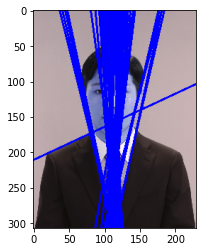

In [25]:
hough_lines('./data/images/image.jpg')

# 顔検出

In [44]:
def face_detect(img):

    face_cascade_path = './haarcascades/haarcascade_frontalface_default.xml'
    face_cascade = cv2.CascadeClassifier(face_cascade_path)

    src = cv2.imread('./data/images/image.jpg')
    src_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(src_gray)
    if faces:
        print(faces) # 左上x,左上y,width,height
    else:
        print("顔検出できなかった")
    bottom_line = 100

    # 描画
    for x, y, w, h in faces:
        cv2.rectangle(src, (x, y), (x + w, y + h), (255, 0, 0), 2)
        bottom_line = x + h
        # 顔幅の1.5倍幅までを分析
        left_line = x - (w*1.5)
        right_line = (x+w) + (w*1.5)
    
    if bottom_line < 100:
        bottom_line = 100
    
    plt.imshow(src)

    return bottom_line
    # cv2.imwrite('./output/opencv_face_detect_rectangle.jpg', src)

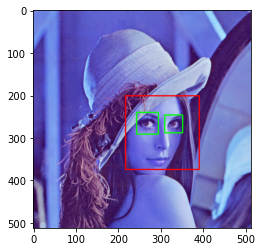

In [45]:
plt.imshow(src)

# 瞳検出

In [28]:
face_cascade_path = './haarcascades/haarcascade_frontalface_default.xml'
eye_cascade_path = './haarcascades/haarcascade_eye.xml'

face_cascade = cv2.CascadeClassifier(face_cascade_path)
eye_cascade = cv2.CascadeClassifier(eye_cascade_path)

src = cv2.imread('./data/images/Lenna_test.png')
src_gray = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(src_gray)

print(faces)

# 描画
for x, y, w, h in faces:
    cv2.rectangle(src, (x, y), (x + w, y + h), (255, 0, 0), 2)
    face = src[y: y + h, x: x + w] # 顔面切り取り
    face_gray = src_gray[y: y + h, x: x + w]
    eyes = eye_cascade.detectMultiScale(face_gray)
    for (ex, ey, ew, eh) in eyes:
        cv2.rectangle(face, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)

# cv2.imwrite('./output/opencv_face_detect_rectangle.jpg', src)

[[217 201 173 173]]


# テスト

In [54]:
result = detect_shoulder('./data/images/image.jpg')
print(result)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

顔検出できなかった
[357 300 400 343  43  43]
[357 302 396 342  39  40]
[276 228 364 216  88 -12]
[255 197 297 244  42  47]
[341 354 382 349  41  -5]
[ 93 348 148 341  55  -7]
[294 198 393 191  99  -7]
[413 345 654 324 241 -21]
[546 327 659 351 113  24]
[109 188 159 219  50  31]
[536 327 647 350 111  23]
[  6 226  79 217  73  -9]
[450 341 657 319 207 -22]
[512 293 652 274 140 -19]
[506 167 569 157  63 -10]
[449 372 485 328  36 -44]
[436 344 477 347  41   3]
[  1 291  89 293  88   2]
[723 304 765 304  42   0]
[573 219 647 219  74   0]
[723 369 767 372  44   3]
[717 260 765 253  48  -7]
[116 413 172 394  56 -19]
[551 259 643 242  92 -17]
[508 292 654 270 146 -22]
[496 309 612 286 116 -23]
[533 318 655 304 122 -14]
[596 337 661 335  65  -2]
[319 337 365 338  46   1]
[571 236 643 266  72  30]
[575 277 626 269  51  -8]
[573 221 645 241  72  20]
[ 97 339 153 333  56  -6]
[581 273 650 261  69 -12]
[553 191 640 180  87 -11]
[581 272 652 257  71 -15]
[576 336 642 351  66  15]
[528 312 655 300 127 -12]
[7

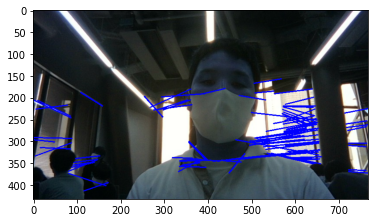

In [51]:
result = detect_shoulder('./data/images/20201120_110619.jpg')
print(result)

顔検出できなかった
[365 166 498 138 133 -28]
[133.]
[28.]
検出できなかった


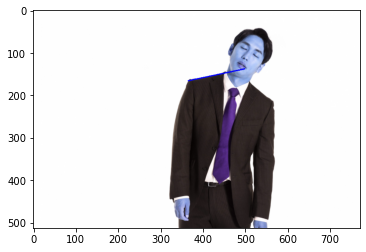

In [52]:
result = detect_shoulder('./data/images/test.jpg')
print(result)

顔検出できなかった
[289 420 398 415 109  -5]
[396 400 608 408 212   8]
[338 415 598 394 260 -21]
[323 425 609 410 286 -15]
[278 428 594 423 316  -5]
[335 425 598 416 263  -9]
[339 423 607 407 268 -16]
[310 418 374 415  64  -3]
[404 397 596 390 192  -7]
[281 427 596 403 315 -24]
[301 429 587 426 286  -3]
[407 402 609 411 202   9]
[502 403 601 395  99  -8]
[283 418 594 382 311 -36]
[324 426 416 423  92  -3]
[295 430 546 430 251   0]
[278 426 589 402 311 -24]
[330 416 454 407 124  -9]
[282 142 439 150 157   8]
[480 345 594 388 114  43]
[189 349 229 336  40 -13]
[289 165 435 164 146  -1]
[397 427 596 424 199  -3]
[338 429 541 429 203   0]
[294 431 561 431 267   0]
[282 145 436 166 154  21]
[396 399 505 400 109   1]
[285 156 380 143  95 -13]
[444 411 602 396 158 -15]
[553 332 593 379  40  47]
[387 133 415 177  28  44]
[312 401 364 399  52  -2]
[430 399 592 379 162 -20]
[284 175 440 143 156 -32]
[323 396 578 425 255  29]
[255 324 300 279  45 -45]
[351 412 584 385 233 -27]
[371 423 579 414 208  -9]
[4

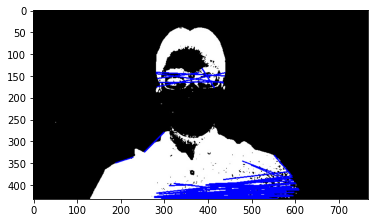

In [53]:
result = detect_shoulder('./data/images/diff.jpg')
print(result)